## Environment setup and loading of data

In [111]:
# load dependencies

# misc
import datetime
import os, sys, shutil

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm

# charting
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers, applications
from keras.applications import VGG19
from keras import layers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import models
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from keras.applications import ResNet50


In [2]:
# set file path variables
train_path = '/content/drive/My Drive/aptos2019-blindness-detection/train_images/'
test_path = '/content/drive/My Drive/aptos2019-blindness-detection/test_images/'

In [3]:
# load csv files with image file names and labels as pandas dataframes
train_data = pd.read_csv('/content/drive/My Drive/aptos2019-blindness-detection/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/data_organized/aptos2019-blindness-detection/test.csv')

In [5]:
# look at test data
test_data.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [6]:
# number of images in test & train data
print('Number of images in training set is {}'.format(len(train_data)))
print('Number of images in test set is {}'.format(len(test_data)))

Number of images in training set is 3662
Number of images in test set is 1928


In [7]:
# store the class information in some variables for convenience
class_labels = [0,1,2,3,4]
class_dict = {0:'No Glaucoma', 1:'Mild Glaucoma', 2:'Moderate Glaucoma', 3:'Severe Glaucoma', 4:'Proliferative Glaucoma'}
class_list = ['No Glaucoma', 'Mild Glaucoma', 'Moderate Glaucoma', 'Severe Glaucoma', 'Proliferative Glaucoma']

In [8]:
# look at the distribution of the training data into the 5 classes
train_data.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

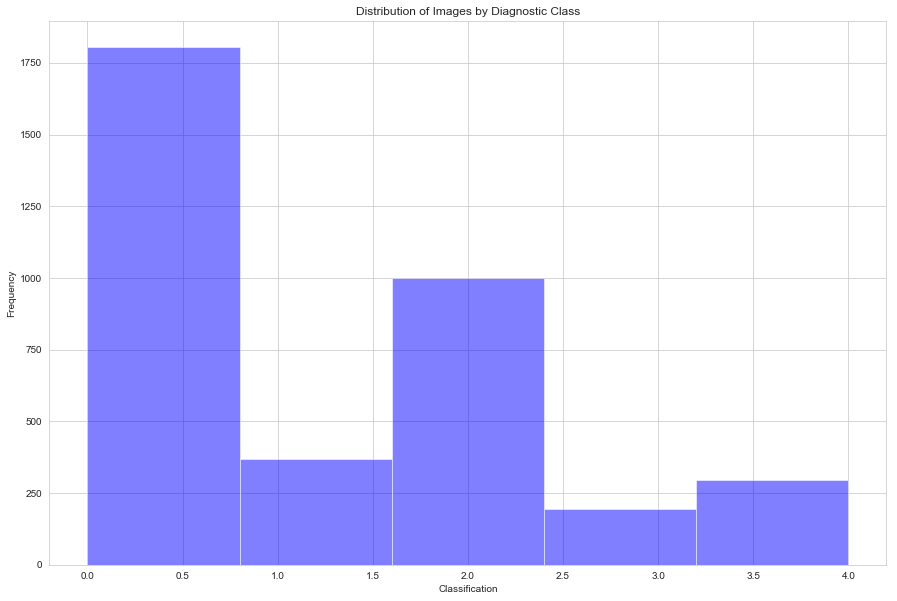

In [149]:
# plot the distribution of images by class
fig, ax = plt.subplots(1, 1, figsize=(15,10))

plt.hist(train_data.diagnosis, 5, facecolor='blue', alpha=0.5)

plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title(r'Distribution of Images by Diagnostic Class')
plt.show()

The training data is not balanced which is typical of disease related datasets, . Class 0 has by far the highest frequency and classes 3 and 4, the most serious from a disease perspective, are in relatively small proportions. In theory (given sufficient data) convolutional neural networks do not need balanced data to perform well. I did  not utilize any methods to balance the classes but this an area that could be explored in the future if the model's performance is not good enough. 


In [10]:
# Related read: Development and Validation of a Deep Learning Algorithm for Detection of Diabetic Retinopathy in Retinal Fundus Photographs
# at: https://jamanetwork.com/journals/jama/fullarticle/2588763?appId=scweb

In [11]:
# function to show some images

def show_15_images(df, category):
    # category is 0, 1, 2, 3, 4
    rows = 3
    columns = 5
    fig, ax = plt.subplots(rows, columns, figsize=(15,10))
    
    title = class_list[category]
    images = df[df['diagnosis'] == category][:15].id_code.values
    
    for sample in range (0, 15):
        image = Image.open(os.path.join(train_path, images[sample] + '.png'))
        
        col = sample // columns
        row = sample % columns
        ax[col, row].imshow(image)
        ax[col, row].axis('off')
    
    plt.suptitle(title)
    plt.show()

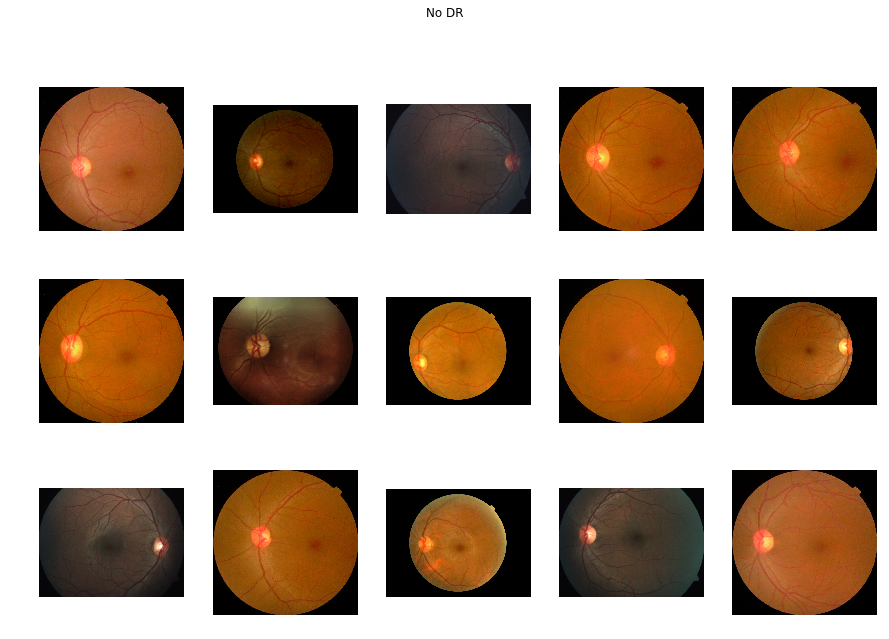

In [12]:
# look at some class 0 images
show_15_images(train_data, 0)

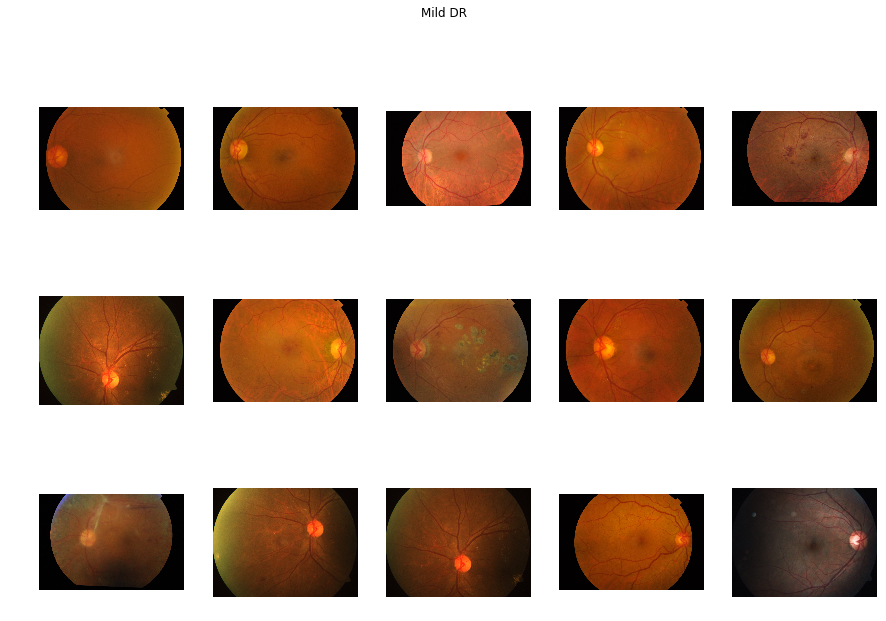

In [13]:
# look at some class 1 images
show_15_images(train_data, 1)

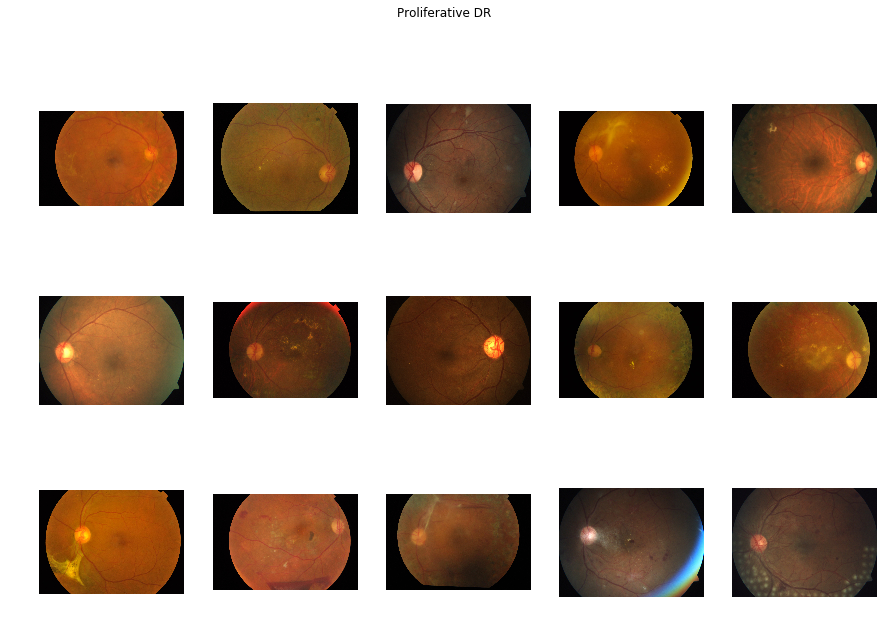

In [14]:
# look at some class 4 images
show_15_images(train_data, 4)

The images vary in dimensions, contrast, brightness, and orientation. Additionally, the images have varying amounts of black wsurrounding the circular image of the retina. If this black area is correlated with the class value this could be a problem, as the CNN will learn to predict based on the black area, which is obviously not what I want the model to be looking at. Time permitting I will attempt to investigate this further and try some methods to reduce the effect of the black areas. 

In [12]:
# function to determine largest and smallest dimensions of the images
def get_dimensions(df, path):
    max_width = 0
    max_height = 0
    min_width = 0
    max_height = 0
    
    file_names = df['id_code']
    
    for index, file_name in enumerate(file_names):
        current_image = Image.open(os.path.join(path, file_name + '.png'))

        width, height = current_image.size
        
        # set initial values
        if max_width == 0:
            max_width = width
            min_width = width
            max_height = height
            min_height = height
        
        if width > max_width:
            max_width = width
        if width < min_width:
            min_width = width
            
        if height > max_height:
            max_height = height
        if height < min_height:
            min_height = height
    
    print('Minimum width: {},'.format(min_width))
    print('Maximum width: {},'.format(max_width))
    print('************')
    print('Minimum height: {}'.format(min_height))
    print('Maximum height: {}'.format(max_height))
    

In [13]:
# look at the train images sizes
get_dimensions(train_data, train_path)

Minimum width: 474,
Maximum width: 4288,
************
Minimum height: 358
Maximum height: 2848


In [14]:
# look at the test images sizes
get_dimensions(test_data, test_path)

Minimum width: 640,
Maximum width: 2896,
************
Minimum height: 480
Maximum height: 1958


In [17]:
# set new paths to the directories
train_dir = '/content/drive/My Drive/data_organized/train/'
validation_dir = '/content/drive/My Drive/data_organized/val/'
test_dir = '/content/drive/My Drive/data_organized/test/'


In [30]:
# count the images in each directory
def count_images(path):
    count = 0
    for directory in os.listdir(path):
        count += len(os.listdir(path + "/" + directory))
    return count


In [33]:
total_train = count_images(train_dir)
total_train

2929

In [32]:
total_val = count_images(validation_dir)
total_val

365

In [36]:
total_test = count_images(test_dir)
total_test

368

In [70]:
# CNN model parameters
BATCH_SIZE = 32
EPOCHS = 20  #this take over 16 hours to run, early stopping trials ended at about 6 epochs
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 128
WIDTH = 128
COLORS = 3
N_CLASSES = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


In [71]:
# get all the images in the training directory and reshape and augment them
train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=20,
#       width_shift_range=0.2,   # removed these for time savings
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(HEIGHT, WIDTH), 
        batch_size= BATCH_SIZE,
        shuffle = True,
        class_mode= 'categorical') 


# get all the data in the validation directory and reshape them
val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(
        validation_dir, 
        target_size=(HEIGHT, WIDTH),
        batch_size = BATCH_SIZE,
        class_mode= 'categorical')

# get all the data in the test directory and reshape them
test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
        test_dir, 
        target_size=(HEIGHT, WIDTH), 
        batch_size = 1,
        class_mode= 'categorical',
        shuffle = False)



Found 2929 images belonging to 5 classes.
Found 365 images belonging to 5 classes.
Found 368 images belonging to 5 classes.


In [72]:
# created a function to create models - all using ResNet50 weights
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [73]:
# instantiate and compile a model
model = create_model(input_shape=(HEIGHT, WIDTH, COLORS), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [74]:
# warm up training phase, only two epochs
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history


Epoch 1/2
91/91 [==============================] - 441s 5s/step - loss: 1.3500 - acc: 0.6539 - val_loss: 1.8089 - val_acc: 0.4932
Epoch 2/2
91/91 [==============================] - 433s 5s/step - loss: 0.8186 - acc: 0.7092 - val_loss: 1.8386 - val_acc: 0.4932


In [75]:
# create the model, use early stopping
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [80]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [81]:
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=3, # revert to: epochs=EPOCHS
                              callbacks=callback_list,
                              verbose=1).history

Epoch 1/3
91/91 [==============================] - 580s 6s/step - loss: 0.2080 - acc: 0.9139 - val_loss: 0.2619 - val_acc: 0.9156
Epoch 2/3
91/91 [==============================] - 573s 6s/step - loss: 0.1825 - acc: 0.9242 - val_loss: 0.2388 - val_acc: 0.8964
Epoch 3/3
91/91 [==============================] - 569s 6s/step - loss: 0.1632 - acc: 0.9341 - val_loss: 0.2036 - val_acc: 0.9096


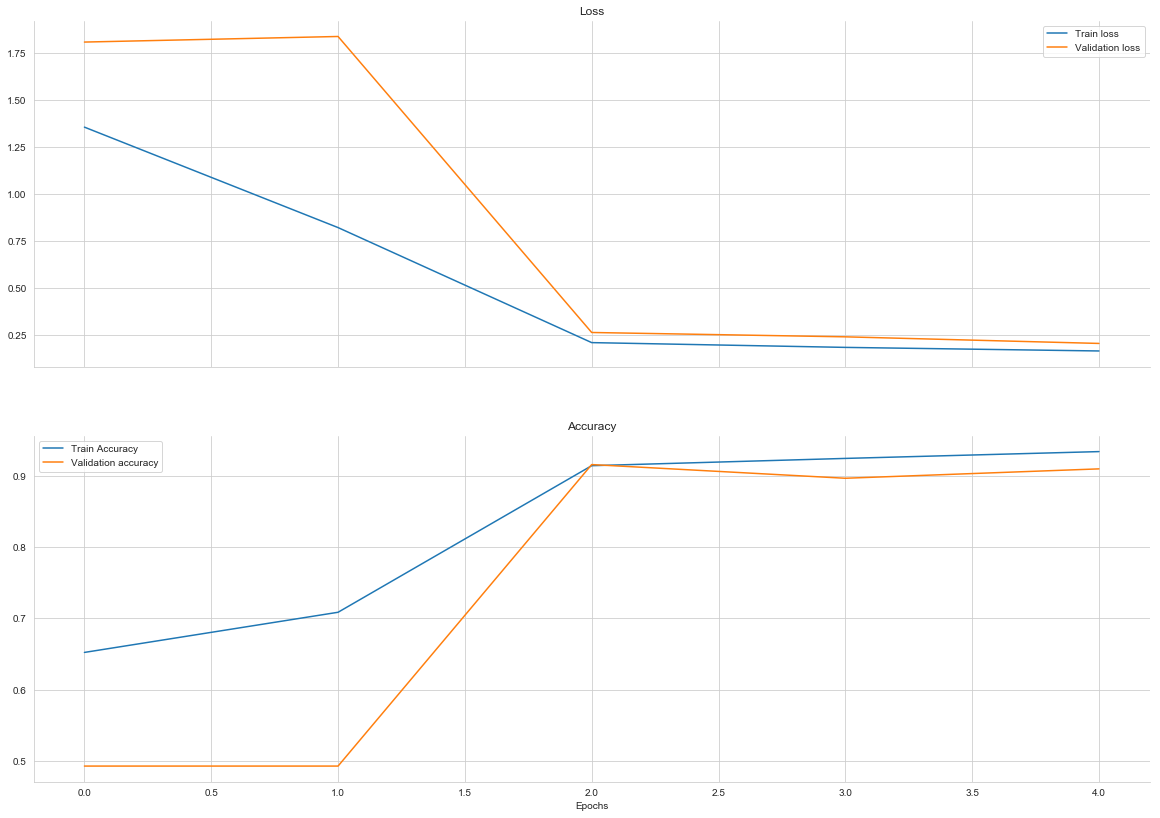

In [82]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [83]:
# save the model

model.save('Final_Model.h5')